## PYSPARK PROJECT: CUSTOMER SEGMENTATION PROJECT

PySpark is a library that helps python users to make use of python to perform data analysis with spark.
Spark is a big data tool. In this project, I will be performing clustering using kmeans to segment customers based on their gender, annual income, age and spending score.

In [0]:
import seaborn as sns
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml.evaluation import ClusteringEvaluator

## DATA LOADING, PREPROCESSSING AND EXPLORATORY DATA ANALYSIS

In [0]:
# File location and type
file_location = "/FileStore/tables/mall_customer_1-1.csv"
file_type = "csv"

df = spark.read.csv(file_location,header=True,inferSchema=True)
df.show()



+----------+------+---+------------------+----------------------+
CustomerID| Genre|Age|Annual Income (k$)|Spending Score (1-100)|
+----------+------+---+------------------+----------------------+
 1| Male| 19| 15| 39|
 2| Male| 21| 15| 81|
 3|Female| 20| 16| 6|
 4|Female| 23| 16| 77|
 5|Female| 31| 17| 40|
 6|Female| 22| 17| 76|
 7|Female| 35| 18| 6|
 8|Female| 23| 18| 94|
 9| Male| 64| 19| 3|
 10|Female| 30| 19| 72|
 11| Male| 67| 19| 14|
 12|Female| 35| 19| 99|
 13|Female| 58| 20| 15|
 14|Female| 24| 20| 77|
 15| Male| 37| 20| 13|
 16| Male| 22| 20| 79|
 17|Female| 35| 21| 35|
 18| Male| 20| 21| 66|
 19| Male| 52| 23| 29|
 20|Female| 35| 23| 98|
+----------+------+---+------------------+----------------------+
only showing top 20 rows

In [0]:
df.printSchema()

root
-- CustomerID: integer (nullable = true)
-- Genre: string (nullable = true)
-- Age: integer (nullable = true)
-- Annual Income (k$): integer (nullable = true)
-- Spending Score (1-100): integer (nullable = true)

In [0]:
data = (df
   .withColumnRenamed('Genre','Gender')
   .withColumnRenamed('Annual Income (k$)', 'Annual_Income')
   .withColumnRenamed('Spending Score (1-100)', 'Spending_Score'))
data.show()

+----------+------+---+-------------+--------------+
CustomerID|Gender|Age|Annual_Income|Spending_Score|
+----------+------+---+-------------+--------------+
 1| Male| 19| 15| 39|
 2| Male| 21| 15| 81|
 3|Female| 20| 16| 6|
 4|Female| 23| 16| 77|
 5|Female| 31| 17| 40|
 6|Female| 22| 17| 76|
 7|Female| 35| 18| 6|
 8|Female| 23| 18| 94|
 9| Male| 64| 19| 3|
 10|Female| 30| 19| 72|
 11| Male| 67| 19| 14|
 12|Female| 35| 19| 99|
 13|Female| 58| 20| 15|
 14|Female| 24| 20| 77|
 15| Male| 37| 20| 13|
 16| Male| 22| 20| 79|
 17|Female| 35| 21| 35|
 18| Male| 20| 21| 66|
 19| Male| 52| 23| 29|
 20|Female| 35| 23| 98|
+----------+------+---+-------------+--------------+
only showing top 20 rows

#let's drop customerID

In [0]:
#let's drop customerID
data = data.drop('CustomerID')
data.show()

+------+---+-------------+--------------+
Gender|Age|Annual_Income|Spending_Score|
+------+---+-------------+--------------+
 Male| 19| 15| 39|
 Male| 21| 15| 81|
Female| 20| 16| 6|
Female| 23| 16| 77|
Female| 31| 17| 40|
Female| 22| 17| 76|
Female| 35| 18| 6|
Female| 23| 18| 94|
 Male| 64| 19| 3|
Female| 30| 19| 72|
 Male| 67| 19| 14|
Female| 35| 19| 99|
Female| 58| 20| 15|
Female| 24| 20| 77|
 Male| 37| 20| 13|
 Male| 22| 20| 79|
Female| 35| 21| 35|
 Male| 20| 21| 66|
 Male| 52| 23| 29|
Female| 35| 23| 98|
+------+---+-------------+--------------+
only showing top 20 rows

#How many customers the Mall has based on the dataset?

In [0]:
print("Total customers:",data.count())

Total customers: 200

#Do we have more female customers?

In [0]:
gen = data.select('Gender').groupBy('Gender').count()

In [0]:
x=gen.toPandas()['Gender'].values.tolist()
y=gen.toPandas()['count'].values.tolist()

#Visualize it

Out[29]:

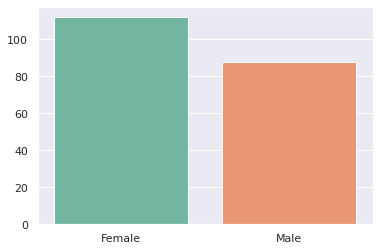

<matplotlib.axes._subplots.AxesSubplot at 0x7fa8d6de4790>

In [0]:
sns.set() 
sns.barplot(x,y,palette='Set2')

In [0]:
data.columns

Out[11]: ['Gender', 'Age', 'Annual_Income', 'Spending_Score']

#How does Gender Influence Spending?

In [0]:
data.groupby('Gender').sum("Spending_Score").show()

+------+-------------------+
Gender|sum(Spending_Score)|
+------+-------------------+
Female| 5771|
 Male| 4269|
+------+-------------------+

#check the statistics summary

In [0]:
data.summary().show()

+-------+------+-----------------+-----------------+------------------+
summary|Gender| Age| Annual_Income| Spending_Score|
+-------+------+-----------------+-----------------+------------------+
 count| 200| 200| 200| 200|
 mean| null| 38.85| 60.56| 50.2|
 stddev| null|13.96900733155888|26.26472116527124|25.823521668370173|
 min|Female| 18| 15| 1|
 25%| null| 28| 40| 34|
 50%| null| 36| 61| 50|
 75%| null| 49| 78| 73|
 max| Male| 70| 137| 99|
+-------+------+-----------------+-----------------+------------------+

#distribution of spending score

Out[14]:

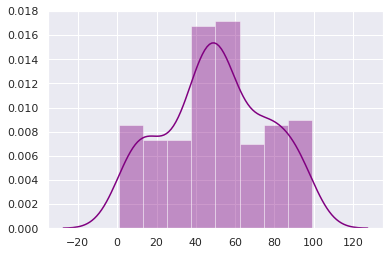

<matplotlib.axes._subplots.AxesSubplot at 0x7fa8d7269b20>

In [0]:
df_plot = data.toPandas()['Spending_Score'].values.tolist()
sns.distplot(df_plot,color='purple')

#Feature Transformation

In [0]:
indexer=StringIndexer(inputCol='Gender',outputCol="Gender_indexed")
df_t=indexer.fit(data).transform(data)
df_t.show()

+------+---+-------------+--------------+--------------+
Gender|Age|Annual_Income|Spending_Score|Gender_indexed|
+------+---+-------------+--------------+--------------+
 Male| 19| 15| 39| 1.0|
 Male| 21| 15| 81| 1.0|
Female| 20| 16| 6| 0.0|
Female| 23| 16| 77| 0.0|
Female| 31| 17| 40| 0.0|
Female| 22| 17| 76| 0.0|
Female| 35| 18| 6| 0.0|
Female| 23| 18| 94| 0.0|
 Male| 64| 19| 3| 1.0|
Female| 30| 19| 72| 0.0|
 Male| 67| 19| 14| 1.0|
Female| 35| 19| 99| 0.0|
Female| 58| 20| 15| 0.0|
Female| 24| 20| 77| 0.0|
 Male| 37| 20| 13| 1.0|
 Male| 22| 20| 79| 1.0|
Female| 35| 21| 35| 0.0|
 Male| 20| 21| 66| 1.0|
 Male| 52| 23| 29| 1.0|
Female| 35| 23| 98| 0.0|
+------+---+-------------+--------------+--------------+
only showing top 20 rows

#create the independent variables

In [0]:
featureassembler=VectorAssembler(inputCols=['Age','Annual_Income','Spending_Score','Gender_indexed'],outputCol="Independent Features")
output=featureassembler.transform(df_t)
output.show()

+------+---+-------------+--------------+--------------+--------------------+
Gender|Age|Annual_Income|Spending_Score|Gender_indexed|Independent Features|
+------+---+-------------+--------------+--------------+--------------------+
 Male| 19| 15| 39| 1.0|[19.0,15.0,39.0,1.0]|
 Male| 21| 15| 81| 1.0|[21.0,15.0,81.0,1.0]|
Female| 20| 16| 6| 0.0| [20.0,16.0,6.0,0.0]|
Female| 23| 16| 77| 0.0|[23.0,16.0,77.0,0.0]|
Female| 31| 17| 40| 0.0|[31.0,17.0,40.0,0.0]|
Female| 22| 17| 76| 0.0|[22.0,17.0,76.0,0.0]|
Female| 35| 18| 6| 0.0| [35.0,18.0,6.0,0.0]|
Female| 23| 18| 94| 0.0|[23.0,18.0,94.0,0.0]|
 Male| 64| 19| 3| 1.0| [64.0,19.0,3.0,1.0]|
Female| 30| 19| 72| 0.0|[30.0,19.0,72.0,0.0]|
 Male| 67| 19| 14| 1.0|[67.0,19.0,14.0,1.0]|
Female| 35| 19| 99| 0.0|[35.0,19.0,99.0,0.0]|
Female| 58| 20| 15| 0.0|[58.0,20.0,15.0,0.0]|
Female| 24| 20| 77| 0.0|[24.0,20.0,77.0,0.0]|
 Male| 37| 20| 13| 1.0|[37.0,20.0,13.0,1.0]|
 Male| 22| 20| 79| 1.0|[22.0,20.0,79.0,1.0]|
Female| 35| 21| 35| 0.0|[35.0,21.0,35.0,0.0]|
 Male| 20| 21| 66| 1.0|[20.0,21.0,66.0,1.0]|
 Male| 52| 23| 29| 1.0|[52.0,23.0,29.0,1.0]|
Female| 35| 23| 98| 0.0|[35.0,23.0,98.0,0.0]|
+------+---+-------------+--------------+--------------+--------------------+
only showing top 20 rows

In [0]:
output.show()

+------+---+-------------+--------------+--------------+--------------------+
Gender|Age|Annual_Income|Spending_Score|Gender_indexed|Independent Features|
+------+---+-------------+--------------+--------------+--------------------+
 Male| 19| 15| 39| 1.0|[19.0,15.0,39.0,1.0]|
 Male| 21| 15| 81| 1.0|[21.0,15.0,81.0,1.0]|
Female| 20| 16| 6| 0.0| [20.0,16.0,6.0,0.0]|
Female| 23| 16| 77| 0.0|[23.0,16.0,77.0,0.0]|
Female| 31| 17| 40| 0.0|[31.0,17.0,40.0,0.0]|
Female| 22| 17| 76| 0.0|[22.0,17.0,76.0,0.0]|
Female| 35| 18| 6| 0.0| [35.0,18.0,6.0,0.0]|
Female| 23| 18| 94| 0.0|[23.0,18.0,94.0,0.0]|
 Male| 64| 19| 3| 1.0| [64.0,19.0,3.0,1.0]|
Female| 30| 19| 72| 0.0|[30.0,19.0,72.0,0.0]|
 Male| 67| 19| 14| 1.0|[67.0,19.0,14.0,1.0]|
Female| 35| 19| 99| 0.0|[35.0,19.0,99.0,0.0]|
Female| 58| 20| 15| 0.0|[58.0,20.0,15.0,0.0]|
Female| 24| 20| 77| 0.0|[24.0,20.0,77.0,0.0]|
 Male| 37| 20| 13| 1.0|[37.0,20.0,13.0,1.0]|
 Male| 22| 20| 79| 1.0|[22.0,20.0,79.0,1.0]|
Female| 35| 21| 35| 0.0|[35.0,21.0,35.0,0.0]|
 Male| 20| 21| 66| 1.0|[20.0,21.0,66.0,1.0]|
 Male| 52| 23| 29| 1.0|[52.0,23.0,29.0,1.0]|
Female| 35| 23| 98| 0.0|[35.0,23.0,98.0,0.0]|
+------+---+-------------+--------------+--------------+--------------------+
only showing top 20 rows

In [0]:
df_fin = output.select("Independent Features")

## KMEANS CLUSTERING ALGORITHM

In [0]:
evaluator = ClusteringEvaluator(predictionCol='prediction',featuresCol='Independent Features',metricName='silhouette')
for i in range(2,12):
    
    KMeans_=KMeans(featuresCol='Independent Features', k=i)
    
    model=KMeans_.fit(df_fin)
    
    pred=model.transform(df_fin)
    
    
    
    score=evaluator.evaluate(pred)
    
   
    
    print("k:{0}, Silhouette Score:{1}".format(i,score))

k:2, Silhouette Score:0.4613654659155506
k:3, Silhouette Score:0.5463024285685076
k:4, Silhouette Score:0.5602200463415296
k:5, Silhouette Score:0.6315209044462041
k:6, Silhouette Score:0.6410283953579785
k:7, Silhouette Score:0.5393313045449044
k:8, Silhouette Score:0.6211029723927771
k:9, Silhouette Score:0.570473699203474
k:10, Silhouette Score:0.58641776569514
k:11, Silhouette Score:0.5703456409371458

#K=6 has the highiest silhouette score

In [0]:
KMeans_a=KMeans(predictionCol='prediction',featuresCol='Independent Features', k=6)
    
model=KMeans_a.fit(df_fin)
    
prediction=model.transform(df_fin).select('prediction').collect()
labels = [p.prediction for p in prediction ]

In [0]:
df_plot = data.toPandas()
df_plot.head()

Out[21]:

,Gender,Age,Annual_Income,Spending_Score
0,Male,19,15,39
1,Male,21,15,81
2,Female,20,16,6
3,Female,23,16,77
4,Female,31,17,40


#Let's visualize the segmentation of our users into six groups.

#After Clustering

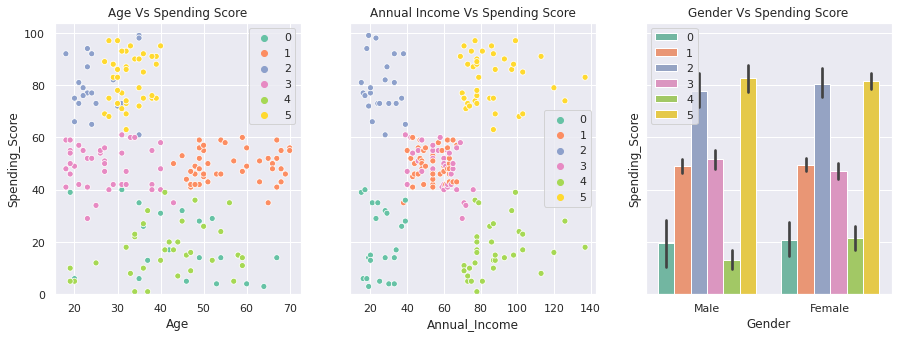

In [0]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)
sns.scatterplot(ax=axes[0],x=df_plot.Age, y=df_plot.Spending_Score,hue=labels,palette='Set2')
axes[0].set_title('Age Vs Spending Score')

sns.scatterplot(ax=axes[1], x=df_plot.Annual_Income, y=df_plot.Spending_Score,hue=labels,palette='Set2')
axes[1].set_title('Annual Income Vs Spending Score')

sns.barplot(ax=axes[2], x=df_plot.Gender, y=df_plot.Spending_Score,hue=labels,palette='Set2')
axes[2].set_title('Gender Vs Spending Score')
axes[2].set_xlabel('Gender')
plt.show()

#Before Clustering

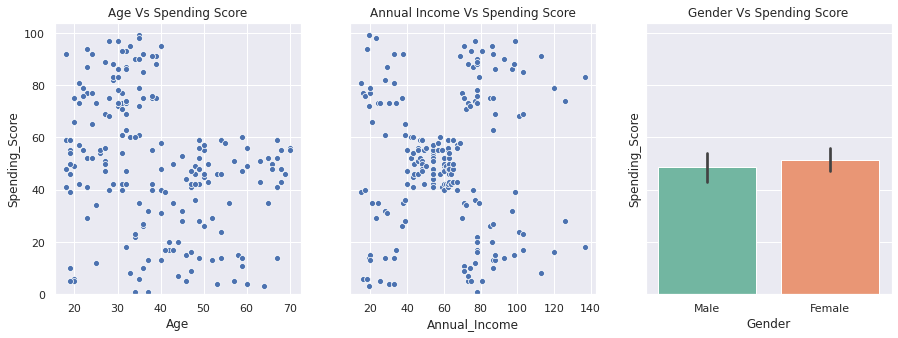

In [0]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)
sns.scatterplot(ax=axes[0],x=df_plot.Age, y=df_plot.Spending_Score,palette='Set2')
axes[0].set_title('Age Vs Spending Score')

sns.scatterplot(ax=axes[1], x=df_plot.Annual_Income, y=df_plot.Spending_Score,palette='Set2')
axes[1].set_title('Annual Income Vs Spending Score')

sns.barplot(ax=axes[2], x=df_plot.Gender, y=df_plot.Spending_Score,palette='Set2')
axes[2].set_title('Gender Vs Spending Score')
axes[2].set_xlabel('Gender')
plt.show()